In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras import callbacks
from collections import Counter
from scipy.stats import randint
import warnings

warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
df['stroke'].value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [4]:
df

id  gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0             0              1          Yes   
1     51676  Female  61.0             0              0          Yes   
2     31112    Male  80.0             0              1          Yes   
3     60182  Female  49.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
...     ...     ...   ...           ...            ...          ...   
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   
5108  37544    Male  51.0             0              0          Yes   
5109  44679  Female  44.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0           Private          Urban             228.69  36.6  formerly smoked   
1     Self-employed          Rural             202.21   NaN     never smoked   
2           Private          Rural             105.92  32.5     never smoked   
3           Private          Urban             171.23  34.4           smokes   
4     Self-employed          Rural             174.12  24.0     never smoked   
...             ...            ...                ...   ...              ...   
5105        Private          Urban              83.75   NaN     never smoked   
5106  Self-employed          Urban             125.20  40.0     never smoked   
5107  Self-employed          Rural              82.99  30.6     never smoked   
5108        Private          Rural             166.29  25.6  formerly smoked   
5109       Govt_job          Urban              85.28  26.2          Unknown   

      stroke  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
5105       0  
5106       0  
5107       0  
5108       0  
5109       0  

[5110 rows x 12 columns]

In [5]:
df.drop(columns=['id'],inplace=True)

In [6]:
df.shape

(5110, 11)

In [7]:
df.describe()

age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.245000   
50%      45.000000      0.000000       0.000000          91.885000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi       stroke  
count  4909.000000  5110.000000  
mean     28.893237     0.048728  
std       7.854067     0.215320  
min      10.300000     0.000000  
25%      23.500000     0.000000  
50%      28.100000     0.000000  
75%      33.100000     0.000000  
max      97.600000     1.000000

In [8]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [9]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [10]:
categorical_columns = df.select_dtypes(include=['object']).columns

label_encoder = LabelEncoder()

for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

In [11]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [12]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(X)
imputed_df = pd.DataFrame(imputed_data, columns=X.columns)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(imputed_df, y, test_size=0.2, random_state=42,stratify=y)

In [14]:
smote = SMOTE(sampling_strategy='auto', random_state=42,k_neighbors=5)
X_synthetic, y_synthetic = smote.fit_resample(X_train, y_train)

# XGBoost

In [15]:
import xgboost as xgb

In [19]:
params = {"objective": "binary:logistic", "num_class": 1,'learning_rate':0.1,'seed':42,'n_estimators':170
          ,'min_child_weight':1,'max_depth': 11,'reg_lambda':0.1}

model = xgb.XGBClassifier(**params)

evals = [(X_synthetic, y_synthetic)]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_synthetic, y_synthetic, cv=cv, scoring="roc_auc")

print("Cross-Validation AUC Scores:", cv_scores)
print("Mean AUC:", np.mean(cv_scores))

Cross-Validation AUC Scores: [0.99505026 0.9935584  0.99252252 0.99109025 0.99478086]
Mean AUC: 0.9934004558924432


In [20]:
model.fit(X_synthetic, y_synthetic)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=170, n_jobs=None, num_class=1,
              num_parallel_tree=None, ...)

In [21]:
y_pred_xg = model.predict(X_test)

In [22]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred_xg)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[960  12]
 [ 42   8]]


In [23]:
balanced_accuracy_score(y_synthetic, model.predict(X_synthetic))

1.0

In [24]:
accuracy_XG = balanced_accuracy_score(y_test, y_pred_xg)
precision_XG = precision_score(y_test, y_pred_xg, pos_label=1)
recall_XG = recall_score(y_test, y_pred_xg, pos_label=1)
f1_XG = f1_score(y_test, y_pred_xg,average='weighted', pos_label=1)

In [25]:
print(f'Accuracy:{accuracy_XG}\nPrecision:{precision_XG}\nRecall:{recall_XG}\nf1:{f1_XG}')

Accuracy:0.5738271604938271
Precision:0.4
Recall:0.16
f1:0.9362415907779608


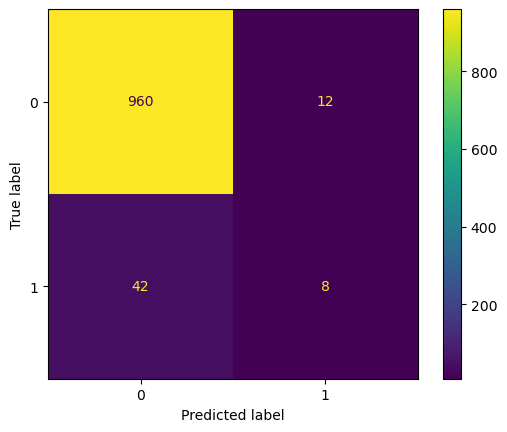

In [26]:
conf_matrix = confusion_matrix(y_test, y_pred_xg)
ConfusionMatrixDisplay(conf_matrix).plot();

# RandomForest

In [414]:
rf_classifier = RandomForestClassifier(n_estimators=120,max_depth=3, random_state=39)

In [415]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X_synthetic, y_synthetic, cv=cv, scoring='roc_auc')
cross_val_scores

array([0.99505026, 0.9935584 , 0.99252252, 0.99109025, 0.99478086])

In [416]:
rf_classifier.fit(X_synthetic, y_synthetic)

RandomForestClassifier(max_depth=3, n_estimators=120, random_state=39)

In [417]:
y_pred_rf = rf_classifier.predict(X_test)

In [418]:
balanced_accuracy_score(y_synthetic, rf_classifier.predict(X_synthetic))

0.8407045512985343

In [308]:
accuracy_rf = balanced_accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, pos_label=1)
recall_rf = recall_score(y_test, y_pred_rf, pos_label=1)
f1_rf = f1_score(y_test, y_pred_rf,average='weighted', pos_label=1)

In [309]:
print(f'Accuracy:{accuracy_rf}\nPrecision:{precision_rf}\nRecall:{recall_rf}\nf1:{f1_rf}')

Accuracy:0.7467695473251028
Precision:0.12794612794612795
Recall:0.76
f1:0.8099108139905403


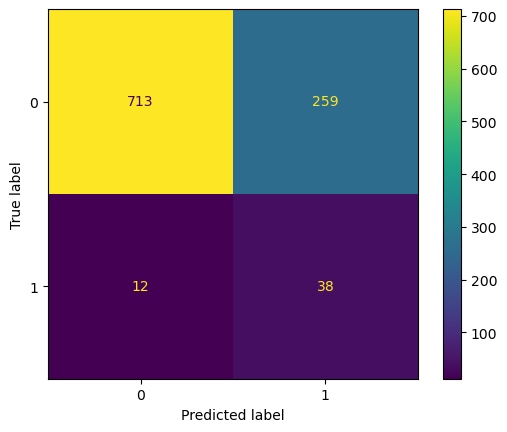

In [310]:
cm = confusion_matrix(y_test, y_pred_rf)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# Stack Classifier

In [365]:
clf1 = LogisticRegression()
clf2 = DecisionTreeClassifier()
clf3 = KNeighborsClassifier(n_neighbors=3)

In [371]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_synthetic)
X_test_normalized = scaler.transform(X_test)


stacking_classifier = StackingClassifier(
    estimators=[('lr', clf1), ('dt', clf2), ('knn', clf3)],
    final_estimator=LogisticRegression(),
    stack_method='auto',
)

In [372]:
stacking_classifier.fit(X_train_normalized, y_synthetic)

y_pred_sc = stacking_classifier.predict(X_test_normalized)

In [373]:
balanced_accuracy_score(y_synthetic, stacking_classifier.predict(X_train_normalized))

0.999742864489586

In [374]:
accuracy_sc = balanced_accuracy_score(y_test, y_pred_sc)
precision_sc = precision_score(y_test, y_pred_sc, pos_label=1)
recall_sc = recall_score(y_test, y_pred_sc, pos_label=1)
f1_sc = f1_score(y_test, y_pred_sc,average='weighted', pos_label=1)

In [375]:
print(f'Accuracy:{accuracy_sc}\nPrecision:{precision_sc}\nRecall:{recall_sc}\nf1:{f1_sc}')

Accuracy:0.5101646090534979
Precision:0.06451612903225806
Recall:0.08
f1:0.903374214486271


In [376]:
cm = confusion_matrix(y_test, y_pred_sc)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# SVM

In [378]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_synthetic)
X_test_normalized = scaler.transform(X_test)

In [379]:
clf = SVC(C=100,kernel='linear')
clf.fit(X_train_normalized,y_synthetic)

SVC(C=100, kernel='linear')

In [380]:
y_pred_svm = clf.predict(X_test_normalized)

In [381]:
balanced_accuracy_score(y_synthetic, clf.predict(X_train_normalized))

0.7714065312419646

In [382]:
accuracy_svm = balanced_accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, pos_label=1)
recall_svm = recall_score(y_test, y_pred_svm, pos_label=1)
f1_svm = f1_score(y_test, y_pred_svm,average='weighted', pos_label=1)

In [383]:
print(f'Accuracy:{accuracy_svm}\nPrecision:{precision_svm}\nRecall:{recall_svm}\nf1:{f1_svm}')

Accuracy:0.7667695473251028
Precision:0.13377926421404682
Recall:0.8
f1:0.8113531418512034


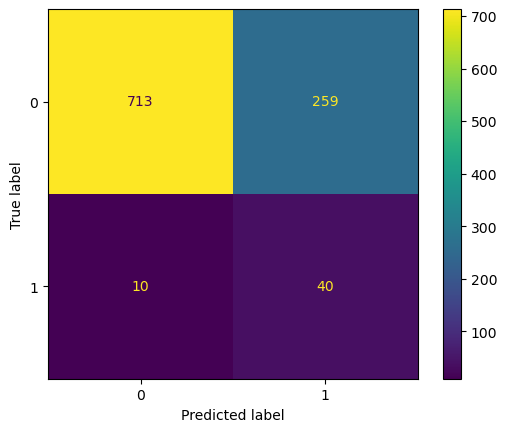

In [385]:
cm = confusion_matrix(y_test, y_pred_svm)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [388]:
plt.plot(['XGBoost', 'Random Forest', 'Stacking Classifier', 'SVM'],[accuracy_XG, accuracy_rf, accuracy_sc, accuracy_svm])
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Algorithms')
plt.show()

# ROC Curve

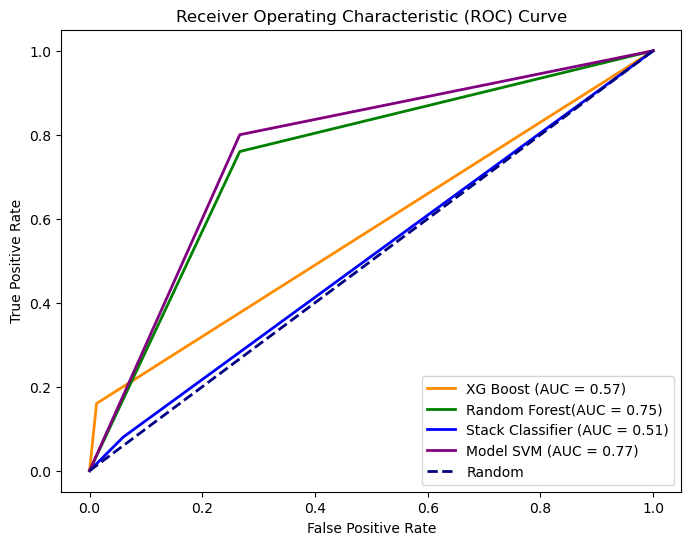

In [390]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_xg)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_rf)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred_sc)
roc_auc3 = auc(fpr3, tpr3)

fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'XG Boost (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='green', lw=2, label=f'Random Forest(AUC = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, color='blue', lw=2, label=f'Stack Classifier (AUC = {roc_auc3:.2f})')
plt.plot(fpr_svm, tpr_svm, color='purple', lw=2, label=f'Model SVM (AUC = {roc_auc_svm:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
